## Setting up Ollama

In [ ]:
!pip install -q -U lightrag[ollama]
!curl -fsSL https://ollama.com/install.sh | sh

## Importing Libraries

In [ ]:
import os
import threading
import subprocess
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import pipeline
import spacy
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from lightrag.core.generator import Generator
from lightrag.core.component import Component
from lightrag.core.model_client import ModelClient
from lightrag.components.model_client import OllamaClient
import random
from datasets import load_dataset

In [ ]:
# Download NLTK data
import nltk
nltk.download('punkt')

In [ ]:
nlp = spacy.load("en_core_web_sm")

## Starting and Initialising Ollama

In [ ]:
def start_ollama():
    os.environ['OLLAMA_HOST'] = '127.0.0.1:11434'  # Bind to localhost
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])
ollama_thread = threading.Thread(target=start_ollama)
ollama_thread.start()

In [ ]:
modelfile_content = f"""FROM {os.path.abspath(r'C:/ML-DL/NUST Projects/unsloth.F16.gguf')}
PARAMETER temperature 0.7
PARAMETER top_p 0.9
"""

# Write Modelfile
with open(r'C:/ML-DL/NUST Projects/Modelfile', 'w') as f:
    f.write(modelfile_content)

In [ ]:
!ollama create financialexam -f ./Modelfile

In [ ]:
# Define QA template
qa_template = r"""<SYS>
You are the expert of Financial Exams, evaluate each Multiple Choice Question and choose the best answer from it. Only Give the best answer in the format it is indicated in the question (e.g A. (relevant text written in the question))
</SYS>

Question: {{question}}

Your answer:"""

In [ ]:
# Define SimpleQA component
class SimpleQA(Component):
    def __init__(self, model_client: ModelClient, model_kwargs: dict):
        super().__init__()
        self.generator = Generator(
            model_client=model_client,
            model_kwargs=model_kwargs,
            template=qa_template,
        )

    def call(self, input: dict) -> str:
        return self.generator.call(input)

In [ ]:
model = {
    "model_client": OllamaClient(),
    "model_kwargs": {"model": "financialexam"}
}

qa = SimpleQA(**model)

## Running Inference

In [ ]:
# Pre-trained model pipelines
query_rewriter_model = pipeline("text2text-generation", model="t5-base", tokenizer="t5-base")
intention_detector_model = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define categories for intention detection
intention_labels = ["Cash", "Accounts Payable", "Inventory", "Retained Earnings"]

In [ ]:
# Query Rewriter
def rewrite_query(query):
    rewritten_query = query_rewriter_model(f"Rewrite the question: {query}", max_length=50, truncation=True)
    return rewritten_query[0]['generated_text']

In [ ]:
# Intention Detector
def detect_intention(query):
    result = intention_detector_model(query, intention_labels)
    top_label = result["labels"][0]
    return top_label

In [ ]:
# Extractor and Refiner
def extract_and_refine(query):
    doc = nlp(query)
    # Extract keywords (nouns, verbs, and named entities)
    keywords = [token.text for token in doc if token.pos_ in ["NOUN", "VERB", "PROPN"]]
    refined_query = " ".join(keywords)
    # Remove special characters (basic refinement)
    refined_query = re.sub(r"[^a-zA-Z0-9\s]", "", refined_query)
    return refined_query

In [ ]:
# Response Generator
def generate_response(refined_query):
    # Pass the refined query to the financialexam model
    response = qa({"question": refined_query}).data
    return response

In [ ]:
# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    if pd.isna(reference) or pd.isna(candidate):  # Handle NaN values
        return 0
    # Convert reference to string if it's not already
    reference = str(reference)
    reference = [reference.split()]
    candidate = str(candidate)
    candidate = candidate.split()
    smoothing_function = SmoothingFunction().method4
    bleu = sentence_bleu(reference, candidate, smoothing_function=smoothing_function)
    return bleu

In [ ]:
# Function to calculate precision, recall, and F1 score
def calculate_prf(reference, candidate):
    if pd.isna(reference) or pd.isna(candidate):  # Handle NaN values
        return 0, 0, 0
    reference = str(reference)
    ref_tokens = reference.split()
    candidate = str(candidate)
    cand_tokens = candidate.split()

    # Binary format for true positives, false positives, etc.
    common_tokens = set(ref_tokens).intersection(set(cand_tokens))
    true_positive = len(common_tokens)
    false_positive = len(set(cand_tokens) - common_tokens)
    false_negative = len(set(ref_tokens) - common_tokens)

    # Handling edge case where no common tokens
    if len(ref_tokens) == 0 or len(cand_tokens) == 0:
        precision, recall, f1 = 0, 0, 0
    else:
        precision = precision_score([1]*len(ref_tokens), [1 if t in common_tokens else 0 for t in ref_tokens], zero_division=0)
        recall = recall_score([1]*len(ref_tokens), [1 if t in common_tokens else 0 for t in ref_tokens], zero_division=0)
        f1 = f1_score([1]*len(ref_tokens), [1 if t in common_tokens else 0 for t in ref_tokens], zero_division=0)

    return precision, recall, f1

In [ ]:
def run_enhanced_inference_and_evaluate():
    print("Running enhanced inference and evaluation...")
    
    # Load the test dataset
    file_path = 'test.csv'
    dataset = pd.read_csv(file_path)
    df = pd.DataFrame({'Question': dataset['input'], 'Answer': dataset['output']})

    bleu_scores, precisions, recalls, f1_scores = [], [], [], []
    qa_pairs = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        question = row['Question']
        reference_answer = row['Answer']

        # Pipeline components
        rewritten_query = rewrite_query(question)
        intention = detect_intention(rewritten_query)
        refined_query = extract_and_refine(rewritten_query)
        model_answer = generate_response(refined_query)

        # Append QA pairs for analysis
        qa_pairs.append((question, rewritten_query, intention, refined_query, reference_answer, model_answer))

        # Calculate BLEU and other metrics
        bleu = calculate_bleu(reference_answer, model_answer)
        precision, recall, f1 = calculate_prf(reference_answer, model_answer)

        bleu_scores.append(bleu)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Display random QA pairs with intermediate steps
    print("\nSample Enhanced QA Pairs:")
    sample_qa_pairs = random.sample(qa_pairs, 5)
    for idx, (question, rewritten_query, intention, refined_query, reference_answer, model_answer) in enumerate(sample_qa_pairs, 1):
        print(f"\nQA Pair {idx}:")
        print(f"Original Question: {question}")
        print(f"Rewritten Query: {rewritten_query}")
        print(f"Detected Intention: {intention}")
        print(f"Refined Query: {refined_query}")
        print(f"Reference Answer: {reference_answer}")
        print(f"Model Answer: {model_answer}")

    # Plot metrics as in the original function
    question_numbers = np.arange(1, len(df) + 1)

    plt.figure(figsize=(10, 18))
    plt.subplot(4, 1, 1)
    plt.plot(question_numbers, precisions, label="Precision", marker='o', color='blue')
    plt.title("Precision per Question")
    plt.xlabel("Question Number")
    plt.ylabel("Precision Score")
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(question_numbers, recalls, label="Recall", marker='o', color='orange')
    plt.title("Recall per Question")
    plt.xlabel("Question Number")
    plt.ylabel("Recall Score")
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(question_numbers, f1_scores, label="F1 Score", marker='o', color='green')
    plt.title("F1 Score per Question")
    plt.xlabel("Question Number")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(question_numbers, bleu_scores, label="BLEU Score", marker='o', color='red')
    plt.title("BLEU Score per Question")
    plt.xlabel("Question Number")
    plt.ylabel("BLEU Score")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Summary table
    summary_table = pd.DataFrame({
        "Metric": ["Average BLEU", "Average Precision", "Average Recall", "Average F1 Score"],
        "Score": [np.mean(bleu_scores), np.mean(precisions), np.mean(recalls), np.mean(f1_scores)]
    })

    print(summary_table)

100%|██████████| 250/250 [52:32<00:00, 12.61s/it]



Sample QA Pairs:

QA Pair 1:
Question:  Rebalancing a portfolio using calendar-based approach: Options: A) Ensures better returns during volatile markets. B) Cost-effective during periods of high transaction costs. C) Rebalances based on pre-determined time intervals. D) Is more efficient than threshold-based rebalancing.
Reference Answer: C) Rebalances based on pre-determined time intervals.
Model Answer: C) Rebalances based on pre-determined time intervals.

QA Pair 2:
Question: In the context of capital budgeting, the sensitivity analysis examines:
Options:
A) Changes in project NPV due to changes in one input variable.
B) The probability distribution of all possible project NPVs.
C) The impact of qualitative factors on project acceptance.
D) The relationship between multiple input variables.
Reference Answer: A) Changes in project NPV due to changes in one input variable.
Model Answer: A) Changes in project NPV due to changes in one input variable.

QA Pair 3:
Question: Which of t

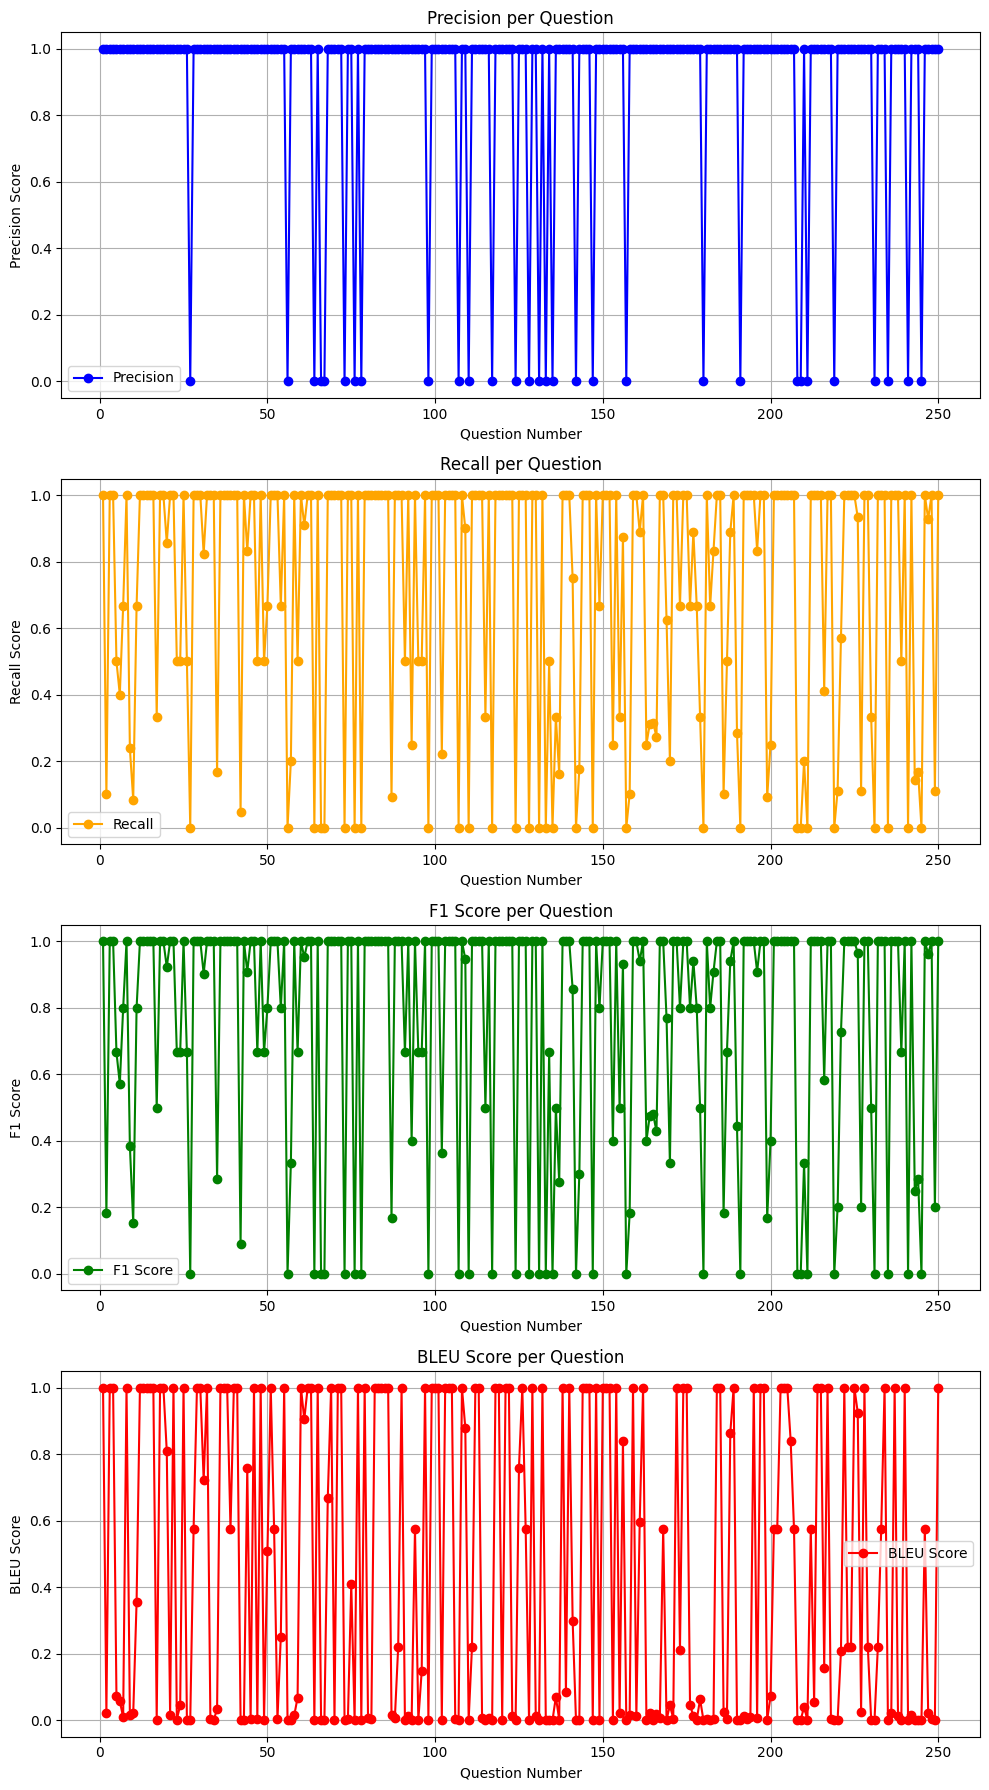


Metrics Summary:
              Metric     Score
0       Average BLEU  0.450395
1  Average Precision  0.880000
2     Average Recall  0.718629
3   Average F1 Score  0.755248


In [ ]:
if __name__ == "__main__":
    run_enhanced_inference_and_evaluate()